In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Tue Oct 20 04:00:53 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    23W / 300W |      0MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.4 gigabytes of available RAM

You are using a high-RAM runtime!


In [4]:
#importing libraries
import pandas as pd
import seaborn as sns
#from io import StringIO
#import requests
from sklearn.preprocessing import LabelEncoder, OneHotEncoder # used for encoding categorical data
from sklearn.preprocessing import StandardScaler # used for feature scaling
from sklearn.metrics import log_loss
from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
# for encoding using feature-engine
#import feature_engine.categorical_encoders
import numpy as n
import random
import pandas as pd
import copy
import time
import matplotlib.pyplot as plt

### EDA & Feature Engineering

The training set contains over 3.7 million records



In [5]:
try:
    df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/training_data.csv", delimiter=";")#,nrows=10000)
    print(" dataset has {} samples with {} features each.".format(*df.shape))
except:
    print("Dataset could not be loaded. Is the dataset missing?")

 dataset has 3738763 samples with 17 features each.


In [6]:
df.head()

,id,timestamp,campaignId,platform,softwareVersion,sourceGameId,country,startCount,viewCount,clickCount,installCount,lastStart,startCount1d,startCount7d,connectionType,deviceType,install
0,5c36658fb58fad351175f0b6,2019-01-09T21:20:15.943+00:00,59687f0d896a6b0e5ce6ea15,ios,11.4.1,1373094,US,25,24,0,2,2019-01-08T18:49:48.129+00:00,1,8,cellular,"iPhone8,2",0
1,5c38d5ab1c16172870186b5a,2019-01-11T17:43:07.609+00:00,59687f0d896a6b0e5ce6ea15,ios,12.1,2739989,US,10,9,2,0,2019-01-09T21:20:22.855+00:00,1,4,cellular,"iPhone9,1",0
2,5c38815de8f4e50e256e4f9c,2019-01-11T11:43:25.168+00:00,59687f0d896a6b0e5ce6ea15,ios,12.1.2,1373094,US,27,26,0,0,2019-01-09T10:42:08.446+00:00,1,2,cellular,"iPhone7,1",0
3,5c409ace532d5806d2c6a5e6,2019-01-17T15:10:06.420+00:00,59687f0d896a6b0e5ce6ea15,ios,12.1.2,1217749,US,15,14,2,0,2019-01-16T19:58:11.636+00:00,3,14,wifi,"iPhone7,2",0
4,5c3904b92d798c41e7f3088a,2019-01-11T21:03:53.145+00:00,59687f0d896a6b0e5ce6ea15,ios,12.0.1,1373094,US,20,18,0,0,2019-01-11T21:03:05.103+00:00,13,18,cellular,"iPhone8,1",0


### Features Engineering

In [7]:
df['day'] = pd.to_datetime(df['timestamp'], infer_datetime_format=True).dt.day
df['hour'] = pd.to_datetime(df['timestamp'], infer_datetime_format=True).dt.hour
df['month'] = pd.to_datetime(df['timestamp'], infer_datetime_format=True).dt.month
df['weekday_name'] = pd.to_datetime(df['timestamp'], infer_datetime_format=True).dt.day_name()


In [8]:
df.head()

,id,timestamp,campaignId,platform,softwareVersion,sourceGameId,country,startCount,viewCount,clickCount,installCount,lastStart,startCount1d,startCount7d,connectionType,deviceType,install,day,hour,month,weekday_name
0,5c36658fb58fad351175f0b6,2019-01-09T21:20:15.943+00:00,59687f0d896a6b0e5ce6ea15,ios,11.4.1,1373094,US,25,24,0,2,2019-01-08T18:49:48.129+00:00,1,8,cellular,"iPhone8,2",0,9,21,1,Wednesday
1,5c38d5ab1c16172870186b5a,2019-01-11T17:43:07.609+00:00,59687f0d896a6b0e5ce6ea15,ios,12.1,2739989,US,10,9,2,0,2019-01-09T21:20:22.855+00:00,1,4,cellular,"iPhone9,1",0,11,17,1,Friday
2,5c38815de8f4e50e256e4f9c,2019-01-11T11:43:25.168+00:00,59687f0d896a6b0e5ce6ea15,ios,12.1.2,1373094,US,27,26,0,0,2019-01-09T10:42:08.446+00:00,1,2,cellular,"iPhone7,1",0,11,11,1,Friday
3,5c409ace532d5806d2c6a5e6,2019-01-17T15:10:06.420+00:00,59687f0d896a6b0e5ce6ea15,ios,12.1.2,1217749,US,15,14,2,0,2019-01-16T19:58:11.636+00:00,3,14,wifi,"iPhone7,2",0,17,15,1,Thursday
4,5c3904b92d798c41e7f3088a,2019-01-11T21:03:53.145+00:00,59687f0d896a6b0e5ce6ea15,ios,12.0.1,1373094,US,20,18,0,0,2019-01-11T21:03:05.103+00:00,13,18,cellular,"iPhone8,1",0,11,21,1,Friday


In [9]:
result = df.deviceType.str.extract('([a-zA-Z]+)([^a-zA-Z]+)', expand=True)
result.columns = ['device_Type', 'device_model']
result.head()

,device_Type,device_model
0,iPhone,"8,2"
1,iPhone,"9,1"
2,iPhone,"7,1"
3,iPhone,"7,2"
4,iPhone,"8,1"


In [10]:
data = pd.concat([df, result], axis=1, sort=False)
data.head()

,id,timestamp,campaignId,platform,softwareVersion,sourceGameId,country,startCount,viewCount,clickCount,installCount,lastStart,startCount1d,startCount7d,connectionType,deviceType,install,day,hour,month,weekday_name,device_Type,device_model
0,5c36658fb58fad351175f0b6,2019-01-09T21:20:15.943+00:00,59687f0d896a6b0e5ce6ea15,ios,11.4.1,1373094,US,25,24,0,2,2019-01-08T18:49:48.129+00:00,1,8,cellular,"iPhone8,2",0,9,21,1,Wednesday,iPhone,"8,2"
1,5c38d5ab1c16172870186b5a,2019-01-11T17:43:07.609+00:00,59687f0d896a6b0e5ce6ea15,ios,12.1,2739989,US,10,9,2,0,2019-01-09T21:20:22.855+00:00,1,4,cellular,"iPhone9,1",0,11,17,1,Friday,iPhone,"9,1"
2,5c38815de8f4e50e256e4f9c,2019-01-11T11:43:25.168+00:00,59687f0d896a6b0e5ce6ea15,ios,12.1.2,1373094,US,27,26,0,0,2019-01-09T10:42:08.446+00:00,1,2,cellular,"iPhone7,1",0,11,11,1,Friday,iPhone,"7,1"
3,5c409ace532d5806d2c6a5e6,2019-01-17T15:10:06.420+00:00,59687f0d896a6b0e5ce6ea15,ios,12.1.2,1217749,US,15,14,2,0,2019-01-16T19:58:11.636+00:00,3,14,wifi,"iPhone7,2",0,17,15,1,Thursday,iPhone,"7,2"
4,5c3904b92d798c41e7f3088a,2019-01-11T21:03:53.145+00:00,59687f0d896a6b0e5ce6ea15,ios,12.0.1,1373094,US,20,18,0,0,2019-01-11T21:03:05.103+00:00,13,18,cellular,"iPhone8,1",0,11,21,1,Friday,iPhone,"8,1"


We can group all the features in the data into the following categories:
        
        Target feature : install
        app feature: platform	softwareVersion	sourceGameId
        device feature: device_model, device_Type, connectionType

To check the NaN values in data set,we will use heat maps

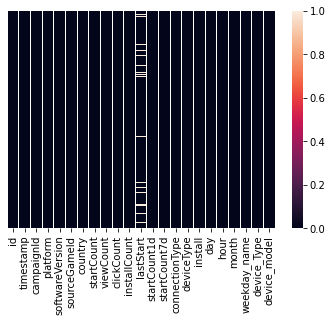

In [11]:
sns.heatmap(data.isna(), yticklabels=False, cbar=True)

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3738763 entries, 0 to 3738762
Data columns (total 23 columns):
 #   Column           Dtype 
---  ------           ----- 
 0   id               object
 1   timestamp        object
 2   campaignId       object
 3   platform         object
 4   softwareVersion  object
 5   sourceGameId     int64 
 6   country          object
 7   startCount       int64 
 8   viewCount        int64 
 9   clickCount       int64 
 10  installCount     int64 
 11  lastStart        object
 12  startCount1d     int64 
 13  startCount7d     int64 
 14  connectionType   object
 15  deviceType       object
 16  install          int64 
 17  day              int64 
 18  hour             int64 
 19  month            int64 
 20  weekday_name     object
 21  device_Type      object
 22  device_model     object
dtypes: int64(11), object(12)
memory usage: 656.1+ MB


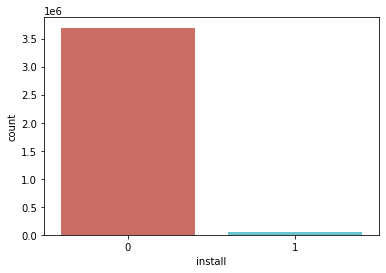

In [14]:
del data["deviceType"]
import seaborn as sns
import matplotlib.pyplot as plt
sns.countplot(x='install',data=data, palette='hls')
plt.show();

In [15]:
data['install'].value_counts()/len(data)

0    0.988032
1    0.011968
Name: install, dtype: float64

The overall install rate is approx. 1%, and approx. 99% is not installed.

The data covers 14 days of click streams data, that is 336 hours.

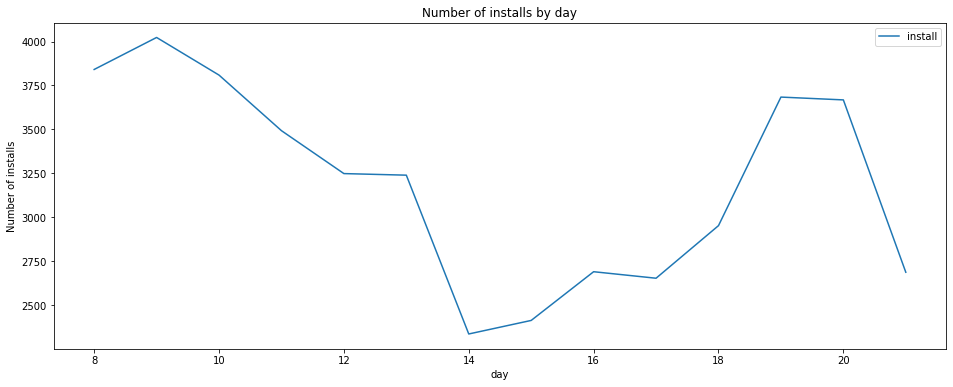

In [16]:
data.groupby('day').agg({'install':'sum'}).plot(figsize=(16,6))
plt.ylabel('Number of installs')
plt.title('Number of installs by day');

On complete data It appears that the most intallations take place on day 8,9 and again 19, 20. However, it maximizes on 8,9 day. 

In [17]:
"""
#Moving averages for day and Hour

rolling_mean = data.install.rolling(window=1).mean()
rolling_mean2 = data.install.rolling(window=24).mean()
plt.plot(data.day, data.install, label='day 1')
plt.plot(data.hour, rolling_mean, label='hour 1', color='orange')
#plt.plot(df.ds, rolling_mean2, label='AMD 50 Day SMA', color='magenta')
plt.legend(loc='upper left')
plt.show()
"""

"\n#Moving averages for day and Hour\n\nrolling_mean = data.install.rolling(window=1).mean()\nrolling_mean2 = data.install.rolling(window=24).mean()\nplt.plot(data.day, data.install, label='day 1')\nplt.plot(data.hour, rolling_mean, label='hour 1', color='orange')\n#plt.plot(df.ds, rolling_mean2, label='AMD 50 Day SMA', color='magenta')\nplt.legend(loc='upper left')\nplt.show()\n"

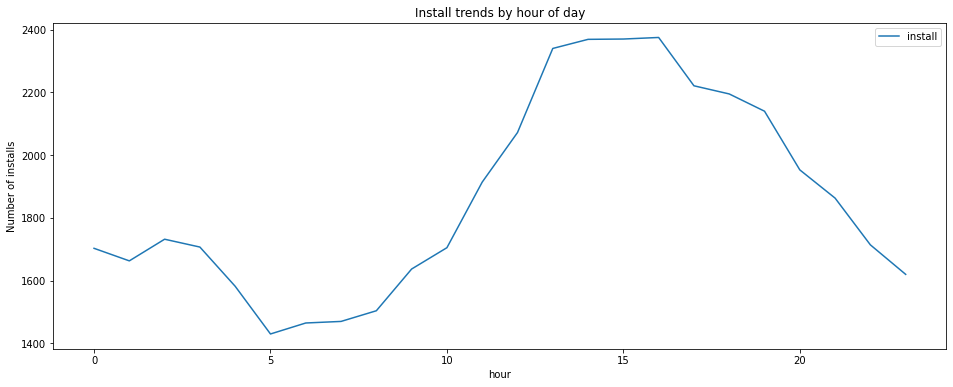

In [17]:
data.groupby('hour').agg({'install':'sum'}).plot(figsize=(16,6))
plt.ylabel('Number of installs')
plt.title('Install trends by hour of day');

The Complete data shows that installations occur mostly at 12 to 2o clock. Noon is the time for highest activity

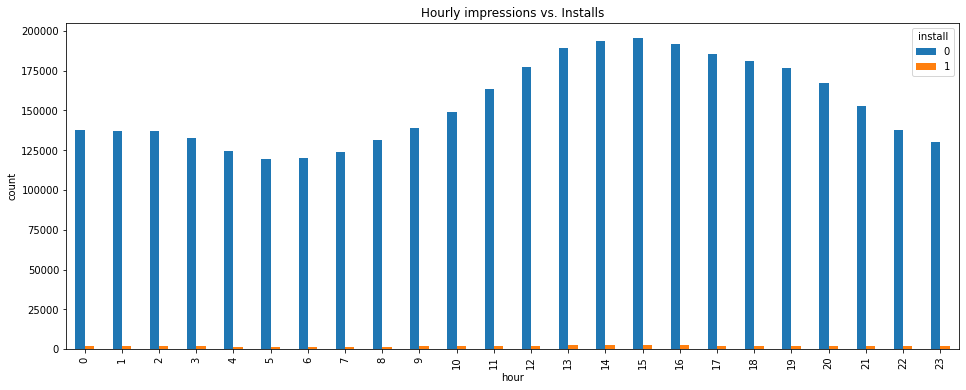

In [18]:
data.groupby(['hour', 'install']).size().unstack().plot(kind='bar', title="Hour of Day", figsize=(16,6))
plt.ylabel('count')
plt.title('Hourly impressions vs. Installs');

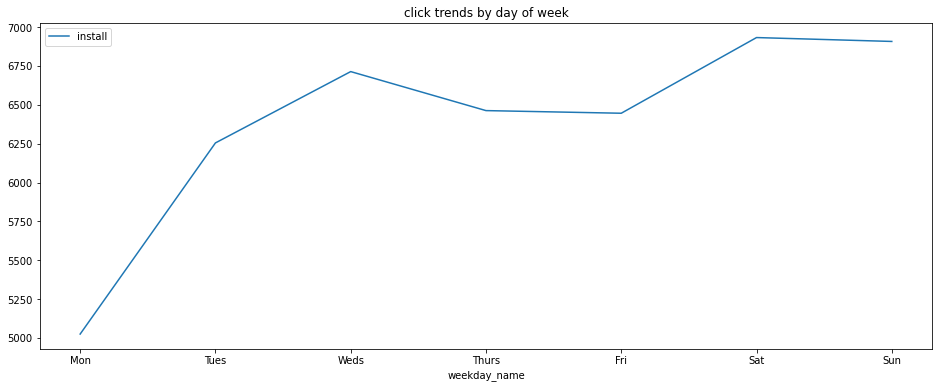

In [19]:
#data['day_of_week'] = data['hour'].apply(lambda val: val.weekday_name)
cats = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
data.groupby('weekday_name').agg({'install':'sum'}).reindex(cats).plot(figsize=(16,6))
ticks = list(range(0, 7, 1)) # points on the x axis where you want the label to appear
labels = "Mon Tues Weds Thurs Fri Sat Sun".split()
plt.xticks(ticks, labels)
plt.title('click trends by day of week');

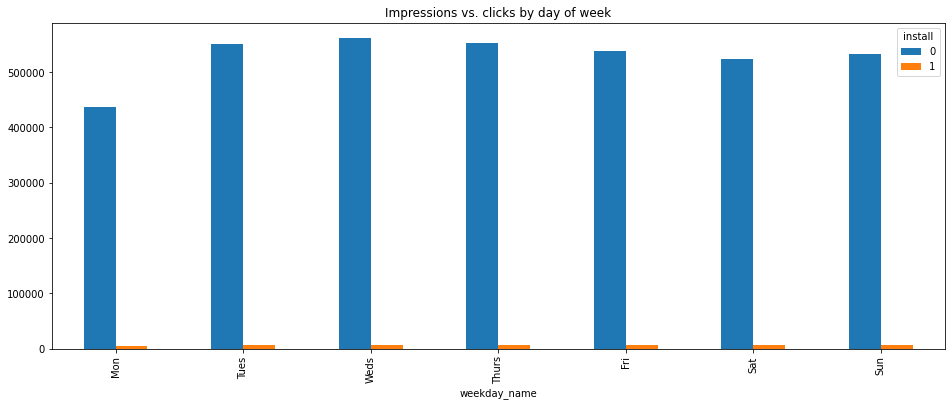

In [20]:
data.groupby(['weekday_name','install']).size().unstack().reindex(cats).plot(kind='bar', title="Day of the Week", figsize=(16,6))
ticks = list(range(0, 7, 1)) # points on the x axis where you want the label to appear
labels = "Mon Tues Weds Thurs Fri Sat Sun".split()
plt.xticks(ticks, labels)
plt.title('Impressions vs. clicks by day of week');

In [21]:
print('The top 10 campaignId that have the most impressions')
print((data.campaignId.value_counts()/len(data))[0:10])



The top 10 campaignId that have the most impressions
5c3bfb0b36c2c6cc18710e7b    0.011164
5c385d02ee4549000d8b9ddd    0.009859
5c0f2ff2f4ee9d00225714c2    0.008788
5afbea849f23a400284f2619    0.008100
5c26db700f371292325680ec    0.007632
5bd2b810eb4bb3b817722baa    0.007275
5af41f3346d16a019f9d327d    0.006455
5c333b4d1d94abf8a325e55a    0.006404
5bd2ccefc9c2110ad461c1b3    0.006262
5ba35fbb478f4102c28b1811    0.006101
Name: campaignId, dtype: float64


In [23]:
"""
data.groupby(['campaignId', 'install']).size().unstack().plot(kind='bar', title="campaignId vs. Installs", figsize=(16,6))
plt.ylabel('count')
plt.title('campaignId vs. Installs');

"""

'\ndata.groupby([\'campaignId\', \'install\']).size().unstack().plot(kind=\'bar\', title="campaignId vs. Installs", figsize=(16,6))\nplt.ylabel(\'count\')\nplt.title(\'campaignId vs. Installs\');\n\n'

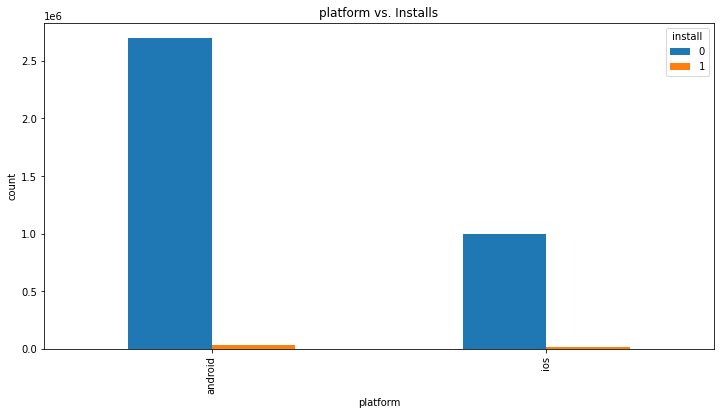

In [22]:
data.groupby(['platform', 'install']).size().unstack().plot(kind='bar', title="platform vs. Installs", figsize=(12,6))
plt.ylabel('count')
plt.title('platform vs. Installs');



In [23]:
print('The top 10 sourceGameId that have the most impressions')
print((data.sourceGameId.value_counts()/len(data))[0:10])


The top 10 sourceGameId that have the most impressions
1711292    0.019567
1483109    0.009385
1782302    0.009096
111890     0.007574
2762289    0.007439
2633648    0.007438
19790      0.007278
2861538    0.007186
19186      0.007005
36615      0.006430
Name: sourceGameId, dtype: float64


In [24]:
sum(data.sourceGameId.value_counts()>=100)

3558

In [25]:
sum(data.sourceGameId.value_counts()>=50)

5413

In [26]:
sum(data.sourceGameId.value_counts()==1)

9314

In [27]:
"""data.groupby(['country', 'install']).size().unstack().plot(kind='bar', title="country vs. Installs", figsize=(16,6))
plt.ylabel('count')
plt.title('country vs. Installs');
"""

print('The top 10 countries that have the most impressions')
print((data.country.value_counts()/len(data))[0:10])

The top 10 countries that have the most impressions
US    0.155062
RU    0.076938
IN    0.071501
BR    0.053639
DE    0.039703
GB    0.034006
FR    0.033323
TR    0.032824
CN    0.031591
ID    0.030993
Name: country, dtype: float64


In [28]:
print('The top 10 device_Type that have the most impressions')
print((data.device_Type.value_counts()/len(data))[0:10])


The top 10 device_Type that have the most impressions
samsung     0.329370
iPhone      0.205815
HUAWEI      0.083807
iPad        0.062178
Xiaomi      0.051495
LGE         0.035727
motorola    0.032523
OPPO        0.030303
vivo        0.019211
LENOVO      0.015121
Name: device_Type, dtype: float64


In [29]:
data.columns

Index(['id', 'timestamp', 'campaignId', 'platform', 'softwareVersion',
       'sourceGameId', 'country', 'startCount', 'viewCount', 'clickCount',
       'installCount', 'lastStart', 'startCount1d', 'startCount7d',
       'connectionType', 'install', 'day', 'hour', 'month', 'weekday_name',
       'device_Type', 'device_model'],
      dtype='object')

In [30]:
data = data[[c for c in data if c not in ['install']] 
       + ['install']]


In [33]:
#we can replace the values of column based on frequency
"""data.loc[data.groupby('country')['id']
         .transform('size')
         .div(len(df))
         .lt(0.20), 
       'country'] = 'Miscellanous'
data.country.value_counts()"""       

"data.loc[data.groupby('country')['id']\n         .transform('size')\n         .div(len(df))\n         .lt(0.20), \n       'country'] = 'Miscellanous'\ndata.country.value_counts()"

In [31]:
weekday_name = pd.get_dummies(data.weekday_name, prefix='weekday_name')
platform = pd.get_dummies(data.platform, prefix='platform')
connectionType = pd.get_dummies(data.connectionType, prefix='connectionType')
country = pd.get_dummies(data.country, prefix='country')


In [32]:
result1 = pd.concat([data, weekday_name], axis=1, sort=False)
result2 = pd.concat([result1, platform], axis=1, sort=False)
result_data = pd.concat([result2, connectionType], axis=1, sort=False)
#The computation becomes impossible on google colab so I dont one hot code countries data
#result_data = pd.concat([result3, country], axis=1, sort=False) 

In [33]:
data = result_data

In [34]:
data.shape

(3738763, 34)

In [35]:
data.head()

,id,timestamp,campaignId,platform,softwareVersion,sourceGameId,country,startCount,viewCount,clickCount,installCount,lastStart,startCount1d,startCount7d,connectionType,day,hour,month,weekday_name,device_Type,device_model,install,weekday_name_Friday,weekday_name_Monday,weekday_name_Saturday,weekday_name_Sunday,weekday_name_Thursday,weekday_name_Tuesday,weekday_name_Wednesday,platform_android,platform_ios,connectionType_cellular,connectionType_none,connectionType_wifi
0,5c36658fb58fad351175f0b6,2019-01-09T21:20:15.943+00:00,59687f0d896a6b0e5ce6ea15,ios,11.4.1,1373094,US,25,24,0,2,2019-01-08T18:49:48.129+00:00,1,8,cellular,9,21,1,Wednesday,iPhone,"8,2",0,0,0,0,0,0,0,1,0,1,1,0,0
1,5c38d5ab1c16172870186b5a,2019-01-11T17:43:07.609+00:00,59687f0d896a6b0e5ce6ea15,ios,12.1,2739989,US,10,9,2,0,2019-01-09T21:20:22.855+00:00,1,4,cellular,11,17,1,Friday,iPhone,"9,1",0,1,0,0,0,0,0,0,0,1,1,0,0
2,5c38815de8f4e50e256e4f9c,2019-01-11T11:43:25.168+00:00,59687f0d896a6b0e5ce6ea15,ios,12.1.2,1373094,US,27,26,0,0,2019-01-09T10:42:08.446+00:00,1,2,cellular,11,11,1,Friday,iPhone,"7,1",0,1,0,0,0,0,0,0,0,1,1,0,0
3,5c409ace532d5806d2c6a5e6,2019-01-17T15:10:06.420+00:00,59687f0d896a6b0e5ce6ea15,ios,12.1.2,1217749,US,15,14,2,0,2019-01-16T19:58:11.636+00:00,3,14,wifi,17,15,1,Thursday,iPhone,"7,2",0,0,0,0,0,1,0,0,0,1,0,0,1
4,5c3904b92d798c41e7f3088a,2019-01-11T21:03:53.145+00:00,59687f0d896a6b0e5ce6ea15,ios,12.0.1,1373094,US,20,18,0,0,2019-01-11T21:03:05.103+00:00,13,18,cellular,11,21,1,Friday,iPhone,"8,1",0,1,0,0,0,0,0,0,0,1,1,0,0


A hash function is a function that maps a set of objects to a set of integers. When using a hash function, this mapping is performed which takes a key of arbitrary length as input and outputs an integer in a specific range.
purposes of the hashing is to minimize memory consumption by the features. Python has a built in function that performs a hash called hash()

In [36]:
def convert_obj_to_int(self):
    
    object_list_columns = self.columns
    object_list_dtypes = self.dtypes
    new_col_suffix = '_int'
    for index in range(0,len(object_list_columns)):
        if object_list_dtypes[index] == object :
            self[object_list_columns[index]+new_col_suffix] = self[object_list_columns[index]].map( lambda  x: hash(x))
            self.drop([object_list_columns[index]],inplace=True,axis=1)
    return self
data = convert_obj_to_int(data)

In [40]:
# Binary Classification with Sonar Dataset: Baseline
from pandas import read_csv
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold

since this is a highly imbalanced dataset we can employ stratified sampling technique 

In [41]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits = 10, test_size = 0.3, random_state = 42)

for training_indices, testing_indices in split.split(data, data["install"]):
        stratified_training_data = data.loc[training_indices]
        stratified_testing_data = data.loc[testing_indices]

In [42]:
stratified_training_data.shape, stratified_testing_data.shape


((2617134, 34), (1121629, 34))

In [43]:
print(data["install"].value_counts()/len(data))

print(stratified_training_data["install"].value_counts()/len(stratified_training_data))
print(stratified_testing_data["install"].value_counts()/len(stratified_testing_data))

0    0.988032
1    0.011968
Name: install, dtype: float64
0    0.988032
1    0.011968
Name: install, dtype: float64
0    0.988033
1    0.011967
Name: install, dtype: float64


In [44]:
count_class_0, count_class_1 = stratified_training_data.install.value_counts()

df_class_0 = stratified_training_data[stratified_training_data['install'] == 0]
df_class_1 = stratified_training_data[stratified_training_data['install'] == 1]

Random over-sampling:
1    2585813
0    2585813
Name: install, dtype: int64


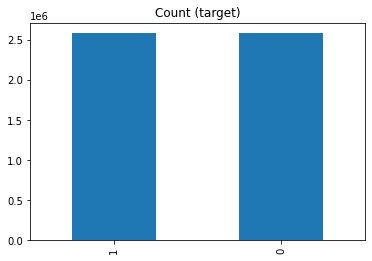

In [45]:
df_class_1_over = df_class_1.sample(count_class_0, replace=True)
df_test_over = pd.concat([df_class_0, df_class_1_over], axis=0)

print('Random over-sampling:')
print(df_test_over.install.value_counts())

df_test_over.install.value_counts().plot(kind='bar', title='Count (target)');

In [46]:
cols = list(df_test_over.columns.values) #Make a list of all of the columns in the df
cols.pop(cols.index('install')) #Remove b from list
X_train = df_test_over[cols]
X_train.shape

(5171626, 33)

In [47]:
y_train = df_test_over["install"]
y_train.shape

(5171626,)

In [48]:
cols = list(stratified_testing_data.columns.values) #Make a list of all of the columns in the df
cols.pop(cols.index('install')) #Remove b from list
X_test = stratified_testing_data[cols]
X_test.shape

(1121629, 33)

In [49]:
y_test = stratified_testing_data["install"]
y_test.shape

(1121629,)

In [50]:
from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler()
min_max_scaler.fit(X_train)
X_train_minmax = min_max_scaler.transform(X_train)
X_test_minmax = min_max_scaler.transform(X_test)

We need to convert both the feature_set and the labels list to the numpy array before we can use it for training. Execute the following script:


In [51]:
import numpy as np
features_set, labels = np.array(X_train_minmax), np.array(y_train)

X_test_features_set, X_test_labels = np.array(X_test_minmax), np.array(y_test)



In order to train LSTM on our data, we need to convert our data into the shape accepted by the LSTM. We need to convert our data into three-dimensional format. 

In [52]:
features_set = np.reshape(features_set, (features_set.shape[0], features_set.shape[1], 1))
X_test_features_set = np.reshape(X_test_features_set, (X_test_features_set.shape[0], X_test_features_set.shape[1], 1))


We have preprocessed our data and have converted it into the desired format. now is the time to create our LSTM. The LSTM model that we are going to create will be a sequential model with multiple layers. We will add four LSTM layers to our model followed by a dense layer that predicts installation

**Modelling approach**

In [53]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout


In [54]:
from tensorflow.keras.callbacks import TensorBoard
import tensorflow
NAME = "MODEL-{}".format(int(time.time()))

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

from keras.callbacks import TensorBoard

In [55]:
#we can train on different set of layers and observe which performs the best
layer_sizes = [16,32,64]

for layer_size in layer_sizes:
    NAME = "{}-nodes-{}".format(layer_size, int(time.time()))
    print(NAME)
    model = Sequential()

    model.add(LSTM(units=layer_size, return_sequences=True, input_shape=(features_set.shape[1], 1)))
    model.add(Dropout(0.2))

    model.add(LSTM(units=layer_size, return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(units=layer_size, return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(units=layer_size))
    model.add(Dropout(0.2))
    model.add(Dense(units = 1))
    tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))
    model.summary()
    model.compile(loss='binary_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy'],
                      )
    
    model.fit(features_set, labels, epochs = 10, batch_size = 512)#since there are 3.7 million training rows so I used 512 batch_size and epoch size=10




16-nodes-1603160626
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 33, 16)            1152      
_________________________________________________________________
dropout (Dropout)            (None, 33, 16)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 33, 16)            2112      
_________________________________________________________________
dropout_1 (Dropout)          (None, 33, 16)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 33, 16)            2112      
_________________________________________________________________
dropout_2 (Dropout)          (None, 33, 16)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 

Tensorboard : TensorFlow's visualization toolkit
Go to cmd and type the following commands

tensorboard --logdir='logs/'
Copy the link and paste on browser to see the visualizations
Go to http://localhost:6006/

since the occam razor principle states that the simplest model is the best model so the max validation accuracy as shown in tensorboard is also visible with this model, I will save the following model and test my model performance on the test dataset


In [60]:
model.save("64-nodes-1603163525")

INFO:tensorflow:Assets written to: 64-nodes-1603163525/assets


In [61]:
import tensorflow as tf
model = tf.keras.models.load_model("/content/64-nodes-1603163525")

**Performance evaluation of the model**

In [62]:
y_pred = model.predict(X_test_features_set)
score = model.evaluate(X_test_features_set, y_test,verbose=1)

print(score)

35051/35051 [==============================] - 233s 7ms/step - loss: 0.6651 - accuracy: 0.5448
[0.6651473045349121, 0.5447549819946289]


**model performance evaluation on test dataset**

In [63]:
try:
    df_test = pd.read_csv("/content/drive/My Drive/Colab Notebooks/test_data.csv", delimiter=";")#),nrows=10000)
    print(" dataset has {} samples with {} features each.".format(*df_test.shape))
except:
    print("Dataset could not be loaded. Is the dataset missing?")
   

 dataset has 3739968 samples with 16 features each.


In [64]:
df_test.head()

,id,timestamp,campaignId,platform,softwareVersion,sourceGameId,country,startCount,viewCount,clickCount,installCount,lastStart,startCount1d,startCount7d,connectionType,deviceType
0,5c4609b6eb7476266130c224,2019-01-21T18:04:38.028+00:00,598c1d93ca9cf7103cf61dcc,android,4.4.2,1515907,RU,6,5,0,0,2019-01-21T17:58:23.728+00:00,6,6,wifi,LENOVO Lenovo A536
1,5c454de3a21d3edde84568d9,2019-01-21T04:43:15.681+00:00,598c1d93ca9cf7103cf61dcc,android,5.1,2724746,MY,1,0,0,1,NaN,1,1,cellular,HUAWEI HUAWEI LUA-U22
2,5c3c4f5769db2eee0c345059,2019-01-14T08:59:03.489+00:00,598c1d93ca9cf7103cf61dcc,android,4.4.4,78130,TR,49,29,4,1,2019-01-14T08:56:10.539+00:00,4,17,wifi,samsung SM-T113
3,5c4476bdf81acd685863a34f,2019-01-20T13:25:17.556+00:00,598c1d93ca9cf7103cf61dcc,android,4.4.4,1261034,TR,1,0,0,1,NaN,1,1,wifi,samsung SM-T113
4,5c456954b7d257ead2f99568,2019-01-21T06:40:20.962+00:00,598c1d93ca9cf7103cf61dcc,android,5.1,1617990,MY,7,4,0,1,2019-01-21T06:38:38.298+00:00,3,7,cellular,OPPO X9009


In [65]:
df_test['day'] = pd.to_datetime(df_test['timestamp'], infer_datetime_format=True).dt.day
df_test['hour'] = pd.to_datetime(df_test['timestamp'], infer_datetime_format=True).dt.hour
df_test['month'] = pd.to_datetime(df_test['timestamp'], infer_datetime_format=True).dt.month
df_test['weekday_name'] = pd.to_datetime(df_test['timestamp'], infer_datetime_format=True).dt.day_name()

In [66]:
result = df_test.deviceType.str.extract('([a-zA-Z]+)([^a-zA-Z]+)', expand=True)
result.columns = ['device_Type', 'device_model']
result.head()

,device_Type,device_model
0,LENOVO,
1,HUAWEI,
2,samsung,
3,samsung,
4,OPPO,


In [67]:
data_test = pd.concat([df_test, result], axis=1, sort=False)
del data_test["deviceType"]
data_test.head()

,id,timestamp,campaignId,platform,softwareVersion,sourceGameId,country,startCount,viewCount,clickCount,installCount,lastStart,startCount1d,startCount7d,connectionType,day,hour,month,weekday_name,device_Type,device_model
0,5c4609b6eb7476266130c224,2019-01-21T18:04:38.028+00:00,598c1d93ca9cf7103cf61dcc,android,4.4.2,1515907,RU,6,5,0,0,2019-01-21T17:58:23.728+00:00,6,6,wifi,21,18,1,Monday,LENOVO,
1,5c454de3a21d3edde84568d9,2019-01-21T04:43:15.681+00:00,598c1d93ca9cf7103cf61dcc,android,5.1,2724746,MY,1,0,0,1,NaN,1,1,cellular,21,4,1,Monday,HUAWEI,
2,5c3c4f5769db2eee0c345059,2019-01-14T08:59:03.489+00:00,598c1d93ca9cf7103cf61dcc,android,4.4.4,78130,TR,49,29,4,1,2019-01-14T08:56:10.539+00:00,4,17,wifi,14,8,1,Monday,samsung,
3,5c4476bdf81acd685863a34f,2019-01-20T13:25:17.556+00:00,598c1d93ca9cf7103cf61dcc,android,4.4.4,1261034,TR,1,0,0,1,NaN,1,1,wifi,20,13,1,Sunday,samsung,
4,5c456954b7d257ead2f99568,2019-01-21T06:40:20.962+00:00,598c1d93ca9cf7103cf61dcc,android,5.1,1617990,MY,7,4,0,1,2019-01-21T06:38:38.298+00:00,3,7,cellular,21,6,1,Monday,OPPO,


In [68]:
#we can replace the value in column based on frequency
"""data_test.loc[data_test.groupby('country')['id']
              .transform('size')
              .div(len(df))
              .lt(0.35), 
            'country'] = 'Miscellanous'"""

"data_test.loc[data_test.groupby('country')['id']\n              .transform('size')\n              .div(len(df))\n              .lt(0.35), \n            'country'] = 'Miscellanous'"

In [69]:
weekday_name = pd.get_dummies(data_test.weekday_name, prefix='weekday_name')
platform = pd.get_dummies(data_test.platform, prefix='platform')
connectionType = pd.get_dummies(data_test.connectionType, prefix='connectionType')
country = pd.get_dummies(data_test.country, prefix='country')


In [70]:
result1 = pd.concat([data_test, weekday_name], axis=1, sort=False)
result2 = pd.concat([result1, platform], axis=1, sort=False)
result_data = pd.concat([result2, connectionType], axis=1, sort=False)
#result_data = pd.concat([result3, country], axis=1, sort=False)


data_test = result_data
data_test.shape

(3739968, 33)

In [71]:
data_test = convert_obj_to_int(data_test)    
data_test_minmax = min_max_scaler.transform(data_test)

In [72]:
import numpy as np
features_set_test = np.array(data_test_minmax)
features_set_test = np.reshape(features_set_test, (features_set_test.shape[0], features_set_test.shape[1], 1))
predictions = model.predict(features_set_test)
#predictions = min_max_scaler.inverse_transform(predictions)

predictions

array([[0.5298393 ],
       [0.69817376],
       [0.4558221 ],
       ...,
       [0.46969208],
       [0.20271349],
       [0.4069739 ]], dtype=float32)

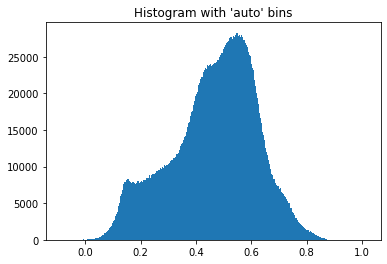

In [73]:
#np.histogram(test_probs, bins=10, range=None, normed=None, weights=None, density=None)
import numpy as np

a = np.hstack(predictions)#(test_probs)
plt.hist(a, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram with 'auto' bins")
#Text(0.5, 1.0, "Histogram with 'auto' bins")
plt.show()


In [74]:
dataframe=pd.DataFrame(predictions, columns=['install_proba']) 
final_prob = pd.concat([df_test["id"], dataframe], axis=1, sort=False)
final_prob.head()


,id,install_proba
0,5c4609b6eb7476266130c224,0.529839
1,5c454de3a21d3edde84568d9,0.698174
2,5c3c4f5769db2eee0c345059,0.455822
3,5c4476bdf81acd685863a34f,0.556308
4,5c456954b7d257ead2f99568,0.609244


In [75]:
import pickle
final_prob.to_pickle("install_proba.pkl")

In [76]:
#import pickle
#final_prob.to_pickle("install_proba.pkl")

final_prob.to_csv("/content/drive/My Drive/Colab Notebooks/install_probability", sep='\t', index=False, encoding='utf-8')

### Feature Importance via Gradient Boosting

Start training...
[10]	valid_0's binary_logloss: 0.0630507	valid_0's l2: 0.0117026
[20]	valid_0's binary_logloss: 0.0624889	valid_0's l2: 0.011688
[30]	valid_0's binary_logloss: 0.0621831	valid_0's l2: 0.0116801
[40]	valid_0's binary_logloss: 0.0620162	valid_0's l2: 0.0116759
[50]	valid_0's binary_logloss: 0.0619101	valid_0's l2: 0.0116738
[60]	valid_0's binary_logloss: 0.0618583	valid_0's l2: 0.0116734
[70]	valid_0's binary_logloss: 0.0618297	valid_0's l2: 0.0116746
[80]	valid_0's binary_logloss: 0.0618167	valid_0's l2: 0.0116761
[90]	valid_0's binary_logloss: 0.0618216	valid_0's l2: 0.0116786
[100]	valid_0's binary_logloss: 0.0618115	valid_0's l2: 0.0116789
[110]	valid_0's binary_logloss: 0.0618052	valid_0's l2: 0.0116804
[120]	valid_0's binary_logloss: 0.061808	valid_0's l2: 0.0116856
[130]	valid_0's binary_logloss: 0.0618018	valid_0's l2: 0.0116865
[140]	valid_0's binary_logloss: 0.0617652	valid_0's l2: 0.0116861
[150]	valid_0's binary_logloss: 0.0617498	valid_0's l2: 0.011688
[160

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: UserWarning: more than one metric available, picking one to plot.


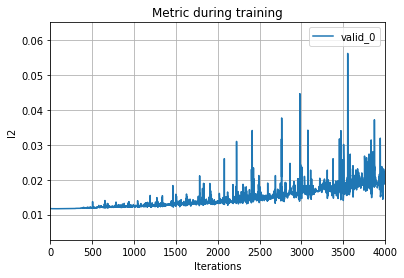

In [37]:
import lightgbm as lgb
import numpy as np

X_train = data.loc[:, data.columns != 'install']
y_target = data.install.values
#create lightgbm dataset
msk = np.random.rand(len(X_train)) < 0.8
lgb_train = lgb.Dataset(X_train[msk], y_target[msk])
lgb_eval = lgb.Dataset(X_train[~msk], y_target[~msk], reference=lgb_train)

# specify your configurations as a dict
params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': { 'mse', 'binary_logloss' },
    'num_leaves': 31, # defauly leaves(31) amount for each tree
    'learning_rate': 0.08,
    'feature_fraction': 0.7, # will select 70% features before training each tree
    'bagging_fraction': 0.3, #feature_fraction, but this will random select part of data
    'bagging_freq': 5, #  perform bagging at every 5 iteration
    'verbose': 0
}

evals_result = {}  # to record eval results for plotting

print('Start training...')
# train
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=4000,
                valid_sets=lgb_eval,
                #feature_name=['f' + str(i + 1) for i in range(28)],
                #categorical_feature=[21],
                evals_result=evals_result,
                #early_stopping_rounds=5000,
               # metric='mse',
                verbose_eval=10)

print('Plot metrics recorded during training...')
ax = lgb.plot_metric(evals_result)#, metric='mse')
plt.show()

Plot feature importances...


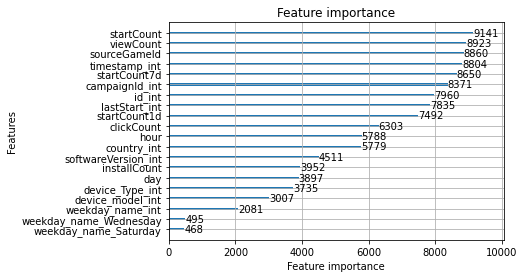

Plot 300th tree...


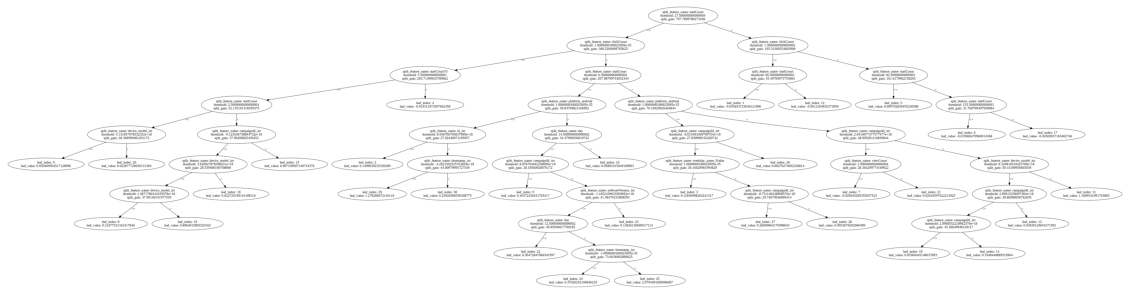

Plot 300th tree with graphviz...


'Tree300.gv.pdf'

In [38]:
print('Plot feature importances...')
ax = lgb.plot_importance(gbm, max_num_features=20)
plt.show()

print('Plot 300th tree...')  # one tree use categorical feature to split
ax = lgb.plot_tree(gbm, tree_index=1, figsize=(20, 15), show_info=['split_gain'])
plt.show()

print('Plot 300th tree with graphviz...')
graph = lgb.create_tree_digraph(gbm, tree_index=1, name='Tree300')
graph.render(view=True)

### Future Works

A sophisticated deep learning model can be used (transfer learning) or reinforcement learning can be employed which is also used for real-time bidding.